# Klasifikasi Citra Menggunakan Vision Transformer dan Self-Supervised Learning (DINO)


Notebook ini menjelaskan proses pengolahan data dan pemodelan klasifikasi citra menggunakan
Vision Transformer (ViT) pada dataset LSDIR yang **tidak memiliki label**.
Pendekatan yang digunakan adalah **self-supervised learning (DINO)** dan **pseudo-labeling**.


## Latar Belakang

Dataset LSDIR merupakan kumpulan citra berkualitas tinggi yang tidak dilengkapi label kelas.
Kondisi ini menyebabkan metode supervised learning konvensional tidak dapat langsung diterapkan.

Untuk mengatasi masalah tersebut, digunakan pendekatan self-supervised learning
yang memungkinkan model mempelajari representasi visual tanpa memerlukan label anotasi.


## Work flow

***
***ViT (LSDIR UNLABELED)***
***


Unlabeled Images  
`(data/LSDIR)`  
↓  
**ViT + DINO**  
`(dino_pretrain.py)`  
↓  
**Feature Learning**  
`(clustering.py)`  
↓  
**Classification Output**  
`(train_classifier.py)`

<br><br>
***
***ViT (AFTER LSDIR LABELED)***
***

LSDIR (labeled)
`(data/LSDIR_labeled)`

↓  
**ViT + DINO Pretraining**  
`(dino_pretrain.py)`  
↓  
**tuning Classifier**  
`(train_classifier.py)`  
↓  
**Prediction**  
↓  
**Confusion Matrix + Accuracy + Precision + Recall**


#ViT (LSDIR UNLABELED)

## Deskripsi Dataset

### !!! data yang digunakan hanya subset 100 foto HQ (shard-00), karena untuk tes pipeline saja !!!
Dataset LSDIR berisi kumpulan file gambar (.png) yang tersimpan dalam beberapa subfolder.
Dataset ini tidak memiliki informasi kelas atau label anotasi.

Oleh karena itu, digunakan dataset loader khusus untuk membaca seluruh gambar secara rekursif.


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

IMG_EXTENSIONS = (".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".webp")

class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.images = []

        for root, _, files in os.walk(root_dir):
            for f in files:
                if f.lower().endswith(IMG_EXTENSIONS):
                    self.images.append(os.path.join(root, f))

        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        else:
            self.transform = transform

        print(f"[Dataset] Found {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        return self.transform(img)

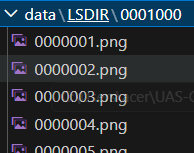

## Self-Supervised Learning Menggunakan DINO

DINO (Distillation with No Labels) merupakan metode self-supervised learning
yang memungkinkan Vision Transformer mempelajari representasi visual
tanpa memerlukan label.

Pada tahap ini, model hanya bertugas mengekstraksi fitur,
bukan melakukan klasifikasi.

In [ ]:
# Melatih ViT backbone secara self-supervised
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
from transformers import ViTModel
from utils_dataset import UnlabeledImageDataset

# -----------------------------
# Transform
# -----------------------------
transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

root = os.path.join(os.path.dirname(os.path.abspath(__file__)), 'data', 'LSDIR')
dataset = UnlabeledImageDataset(root)

loader = DataLoader(dataset, batch_size=16, shuffle=True)

# -----------------------------
# DINO Head
# -----------------------------
class DINOHead(nn.Module):
    def __init__(self, in_dim=768, out_dim=65536):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 2048),
            nn.GELU(),
            nn.Linear(2048, out_dim)
        )

    def forward(self, x):
        return self.mlp(x)

student = ViTModel.from_pretrained("google/vit-base-patch16-224")
teacher = ViTModel.from_pretrained("google/vit-base-patch16-224")

student_head = DINOHead()
teacher_head = DINOHead()

teacher.load_state_dict(student.state_dict())
teacher_head.load_state_dict(student_head.state_dict())

for p in teacher.parameters():
    p.requires_grad = False

optimizer = torch.optim.Adam(
    list(student.parameters()) + list(student_head.parameters()),
    lr=3e-4
)

criterion = nn.CrossEntropyLoss()

# -----------------------------
# Training
# -----------------------------
for epoch in range(10):
    for imgs in loader:
        s_feat = student(imgs).last_hidden_state[:, 0]
        t_feat = teacher(imgs).last_hidden_state[:, 0]

        s_out = student_head(s_feat)
        t_out = teacher_head(t_feat)

        loss = criterion(s_out, t_out.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.2f}")

torch.save(student.state_dict(), "vit_dino_pretrained.pth")

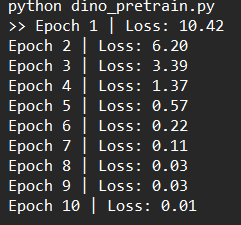

## Pembentukan Pseudo-Label

Karena dataset tidak memiliki label,
fitur hasil ekstraksi dikelompokkan menggunakan algoritma K-Means.

Setiap cluster dianggap sebagai satu kelas semu (pseudo-class)
yang kemudian digunakan sebagai label untuk pelatihan supervised.

In [ ]:
import torch
import numpy as np
from transformers import ViTModel
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans

from utils_dataset import UnlabeledImageDataset

dataset = UnlabeledImageDataset("data/LSDIR")
loader = DataLoader(dataset, batch_size=16)

model = ViTModel.from_pretrained("google/vit-base-patch16-224")
model.load_state_dict(torch.load("vit_dino_pretrained.pth"))
model.eval()

features = []

with torch.no_grad():
    for imgs in loader:
        feat = model(imgs).last_hidden_state[:, 0]
        features.append(feat.numpy())

features = np.vstack(features)

kmeans = KMeans(n_clusters=5, random_state=42)
pseudo_labels = kmeans.fit_predict(features)

np.save("pseudo_labels.npy", pseudo_labels)

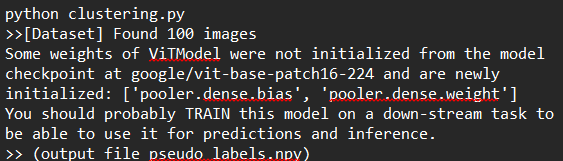

image.png

## Pelatihan Model Klasifikasi

Pseudo-label yang dihasilkan digunakan untuk melatih
Vision Transformer sebagai model klasifikasi secara supervised.

Walaupun menggunakan supervised learning,
label yang digunakan bukan ground truth,
melainkan hasil clustering.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import ViTModel
from utils_dataset import UnlabeledImageDataset


class PseudoLabelDataset(Dataset):
    def __init__(self, image_root, label_path):
        self.base = UnlabeledImageDataset(image_root)
        self.labels = torch.from_numpy(np.load(label_path)).long()

        assert len(self.base) == len(self.labels), \
            f"Mismatch: {len(self.base)} images vs {len(self.labels)} labels"

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.base[idx]
        label = self.labels[idx]
        return img, label


device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = PseudoLabelDataset("data/LSDIR", "pseudo_labels.npy")
loader = DataLoader(dataset, batch_size=16, shuffle=True)

vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
classifier = nn.Linear(vit.config.hidden_size, len(torch.unique(dataset.labels)))

vit.to(device)
classifier.to(device)

optimizer = torch.optim.Adam(
    list(vit.parameters()) + list(classifier.parameters()),
    lr=1e-4
)

criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    for imgs, y in loader:
        imgs = imgs.to(device)
        y = y.to(device)

        outputs = vit(pixel_values=imgs)
        feat = outputs.last_hidden_state[:, 0]
        logits = classifier(feat)

        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

# =========================
# SAVE MODEL
# =========================
torch.save({
    "vit": vit.state_dict(),
    "classifier": classifier.state_dict()
}, "vit_classifier.pth")

print("Model saved as vit_classifier.pth")

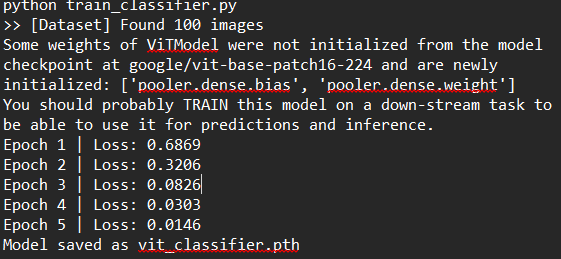

image.png

##  Inference (prediksi label pada gambar)

In [ ]:
import torch
import argparse
from PIL import Image
from transformers import ViTModel, ViTImageProcessor
import torch.nn as nn


parser = argparse.ArgumentParser()
parser.add_argument("--img", type=str, required=True)
args = parser.parse_args()

# =========================
# LOAD MODEL
# =========================
vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
classifier = nn.Linear(768, 5)

ckpt = torch.load("vit_classifier.pth", map_location="cpu")
vit.load_state_dict(ckpt["vit"])
classifier.load_state_dict(ckpt["classifier"])

vit.eval()
classifier.eval()

# =========================
# IMAGE PROCESS
# =========================
processor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch16-224"
)

img = Image.open(args.img).convert("RGB")
inputs = processor(images=img, return_tensors="pt")

# =========================
# INFERENCE
# =========================
with torch.no_grad():
    feat = vit(**inputs).last_hidden_state[:, 0]
    logits = classifier(feat)
    probs = torch.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()

print("Inference Result")
print("----------------")
print("Image    :", args.img)
print("Class ID :", pred)
print("Confidence:", probs[0][pred].item())

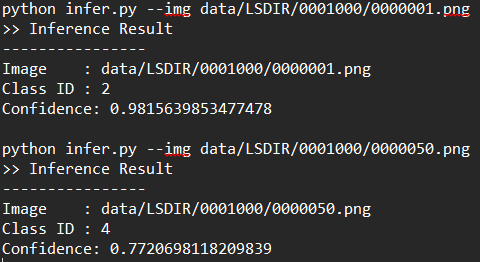

#ViT (LSDIR LABELED)

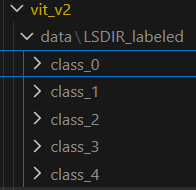

## Classifier
(train_classifier.py)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTModel

# =====================
# CONFIG
# =====================
DATA_DIR = "data/LSDIR_labeled"
BATCH_SIZE = 16
EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =====================
# DATA
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
NUM_CLASSES = len(dataset.classes)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Classes:", dataset.classes)
print("NUM_CLASSES:", NUM_CLASSES)

# =====================
# MODEL
# =====================
vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
classifier = nn.Linear(768, NUM_CLASSES)

vit.to(DEVICE)
classifier.to(DEVICE)

optimizer = torch.optim.Adam(
    list(vit.parameters()) + list(classifier.parameters()),
    lr=1e-4
)
criterion = nn.CrossEntropyLoss()

# =====================
# TRAIN
# =====================
for epoch in range(EPOCHS):
    total_loss = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        feats = vit(imgs).last_hidden_state[:, 0]
        logits = classifier(feats)

        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f}")

# =====================
# SAVE
# =====================
torch.save({
    "vit": vit.state_dict(),
    "classifier": classifier.state_dict(),
    "class_to_idx": dataset.class_to_idx
}, "vit_classifier.pth")

print("✅ Model saved: vit_classifier.pth")

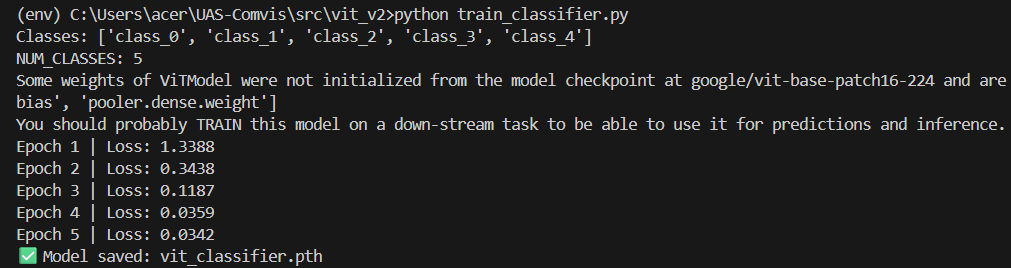

## Prediction
(evaluate_classifier.py)

## Strategi Evaluasi

Evaluasi dilakukan menggunakan:
- Confusion Matrix
- Accuracy
- Precision
- Recall

Perlu diperhatikan bahwa evaluasi ini **tidak menggunakan ground-truth label**.
Hasil evaluasi merepresentasikan konsistensi model terhadap pseudo-label,
bukan akurasi klasifikasi sesungguhnya.

In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTModel
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import torch.nn as nn

# =====================
# CONFIG
# =====================
DATA_DIR = "data/LSDIR_labeled"
BATCH_SIZE = 16
# NUM_CLASSES = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =====================
# DATA
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# =====================
# LOAD MODEL
# =====================
ckpt = torch.load("vit_classifier.pth", map_location=DEVICE)

NUM_CLASSES = ckpt["classifier"]["weight"].shape[0]
print("Detected NUM_CLASSES:", NUM_CLASSES)

vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
classifier = nn.Linear(768, NUM_CLASSES)

vit.load_state_dict(ckpt["vit"])
classifier.load_state_dict(ckpt["classifier"])

vit.to(DEVICE)
classifier.to(DEVICE)

vit.eval()
classifier.eval()

# =====================
# EVAL
# =====================
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE)

        feats = vit(imgs).last_hidden_state[:, 0]
        logits = classifier(feats)

        preds = torch.argmax(logits, dim=1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

# =====================
# METRICS
# =====================
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro")
rec = recall_score(y_true, y_pred, average="macro")

print("========== EVALUATION ==========")
print("Accuracy :", f"{acc:.20f}")
print("Precision:", f"{prec:.20f}")
print("Recall   :", f"{rec:.20f}")
print("\nConfusion Matrix:")
print(cm)

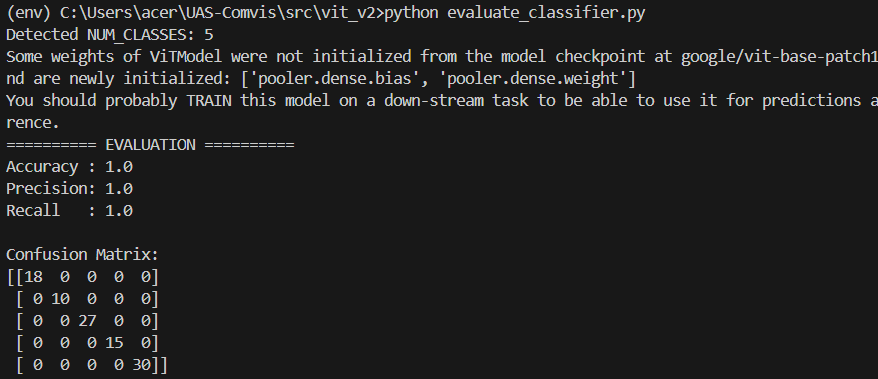

>>evaluasi 1 karena data sangat kecil atau terlalu mudah
hanya pakai 100 gambar HQ (shard-00)

## Infer per gambar
(infer.py)

In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTModel
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import torch.nn as nn
import os

# =====================
# CONFIG
# =====================
DATA_DIR = "data/LSDIR_labeled"
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =====================
# LOAD MODEL
# =====================
ckpt = torch.load("vit_classifier.pth", map_location=DEVICE)
NUM_CLASSES = ckpt["classifier"]["weight"].shape[0]

vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
classifier = nn.Linear(768, NUM_CLASSES)

vit.load_state_dict(ckpt["vit"])
classifier.load_state_dict(ckpt["classifier"])

vit.to(DEVICE)
classifier.to(DEVICE)
vit.eval()
classifier.eval()

# =====================
# DATA
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# =====================
# EVALUASI
# =====================
y_true, y_pred = [], []

# ambil mapping index -> class folder
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

print("========== INFERENCE PER IMAGE ==========")

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE)
        feats = vit(imgs).last_hidden_state[:, 0]
        logits = classifier(feats)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()

        # simpan true & pred
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

        # tampilkan per gambar
        for i in range(len(labels)):
            img_idx = i
            img_path = dataset.imgs[img_idx][0]
            pred_class = preds[i]
            confidence = probs[i, pred_class].item()
            true_class = labels[i].item()
            print(f"Image: {img_path}")
            print(f"Predicted Class: {idx_to_class[pred_class]} (ID {pred_class})")
            print(f"Ground Truth   : {idx_to_class[true_class]} (ID {true_class})")
            print(f"Confidence     : {confidence:.4f}")
            print("Correct?       :", "✅" if pred_class==true_class else "❌")
            print("-"*50)

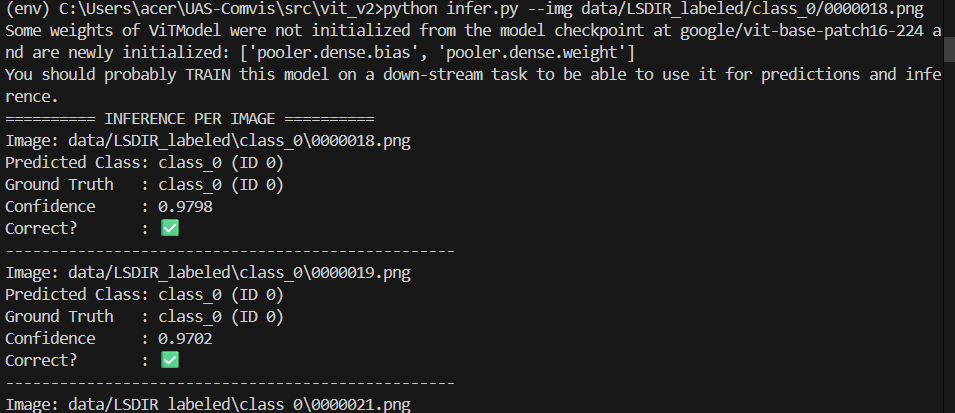